In [1]:
import os
import tifffile as tiff
import cv2
import numpy as np
import numpy as np
from sklearn.model_selection import train_test_split
import shutil as sh 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2DTranspose,ZeroPadding2D,Conv2D,Add,Dropout,Input,UpSampling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import load_img,img_to_array,plot_model 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint,EarlyStopping,Callback

In [2]:
os.chdir(r'C:\Users\sanch\epfl')

In [3]:
data=tiff.imread("volumedata.tif")

In [4]:
data.shape

(1065, 1536, 2048)

In [5]:
data[0]

array([[101, 131, 119, ..., 120, 115,  81],
       [ 97, 108, 116, ..., 110, 111, 112],
       [117, 106, 116, ..., 108, 109,  90],
       ...,
       [114, 104,  90, ..., 152, 162, 178],
       [109,  95,  81, ..., 159, 166, 162],
       [ 99,  89,  81, ..., 143, 165, 160]], dtype=uint8)

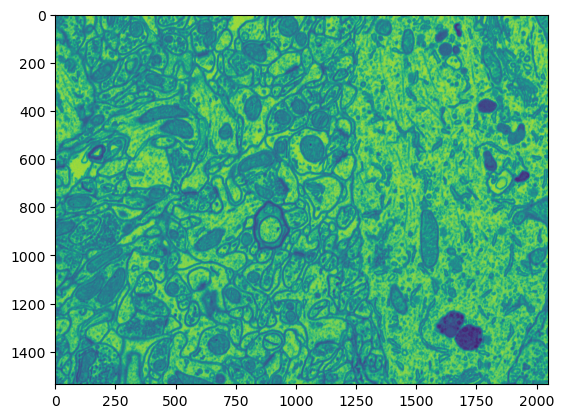

In [6]:
image_array = data[1]
plt.imshow(image_array)
plt.show()


In [7]:
if not os.path.isdir("/input/electron-microscopy-3d-segmentation/data/images"):
      os.makedirs("/input/electron-microscopy-3d-segmentation/data/images")
if not os.path.isdir("/input/electron-microscopy-3d-segmentation/data/masks"):
      os.makedirs("/input/electron-microscopy-3d-segmentation/data/masks")

In [8]:
Train_images=tiff.imread("training.tif")
Train_masks=tiff.imread("training_groundtruth.tif")
Train_images.shape
Train_masks.shape

(165, 768, 1024)

In [9]:
for img in range(Train_images.shape[0]):
    img_name = "image_{}.jpg".format(img)
    cv2.imwrite("/input/electron-microscopy-3d-segmentation/data/images/{}".format(img_name), Train_images[img])
    mask_name = "mask_{}_L.jpg".format(img)
    cv2.imwrite("/input/electron-microscopy-3d-segmentation/data/masks/{}".format(mask_name), Train_masks[img])


In [11]:
if not os.path.isdir("data/images"):
    os.makedirs("data/images")
if not os.path.isdir("data/masks"):
    os.makedirs("data/masks")
for img in range(Train_images.shape[0]):
    img_name = "image_{}.jpg".format(img)
    cv2.imwrite("data/images/{}".format(img_name), Train_images[img])
    mask_name = "mask_{}_L.jpg".format(img)
    cv2.imwrite("data/masks/{}".format(mask_name), Train_masks[img])


In [13]:
images=os.listdir(r"C:\Users\sanch\epfl\data\images")
masks=os.listdir(r"C:\Users\sanch\epfl\data\masks")
Train_images,Val_images,Train_masks,Val_masks=train_test_split(images,masks,test_size=.2,shuffle=True)

In [14]:
print(Train_images[:3])
print(Train_masks[:3])

['image_161.jpg', 'image_114.jpg', 'image_138.jpg']
['mask_163_L.jpg', 'mask_116_L.jpg', 'mask_13_L.jpg']


In [15]:
for name in images :
  if name in Train_images:
    path2save="Train"
  if name in Val_images:
    path2save="Val"
  if not os.path.isdir(r"C:\Users\sanch\epfl\{}\images".format(path2save)):
      os.makedirs(r"C:\Users\sanch\epfl\{}\images".format(path2save))
  sh.move(r"C:\Users\sanch\epfl\data\images\{}".format(name),r"C:\Users\sanch\epfl\{}\images\{}".format(path2save,name))

In [16]:
for name in masks :
  if name in Train_masks:
    path2save="Train"
  if name in Val_masks:
    path2save="Val"
  if not os.path.isdir(r"C:\Users\sanch\epfl\{}\masks".format(path2save)):
      os.makedirs(r"C:\Users\sanch\epfl\{}\masks".format(path2save))
  sh.move(r"C:\Users\sanch\epfl\data\masks\{}".format(name),r"C:\Users\sanch\epfl\{}\masks\{}".format(path2save,name))

In [17]:
if os.path.exists("/input/electron-microscopy-3d-segmentation/data"):
    sh.rmtree("/input/electron-microscopy-3d-segmentation/data")

File Deleted


In [18]:
def Load_image(path,Size):
    img = cv2.imread(path)
    img=cv2.resize(img,(Size,Size))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img=img/255.
    return img

In [19]:
def show_image(image, title=None):
    plt.imshow(image,cmap='gray')
    plt.title(title)
    plt.axis('off')

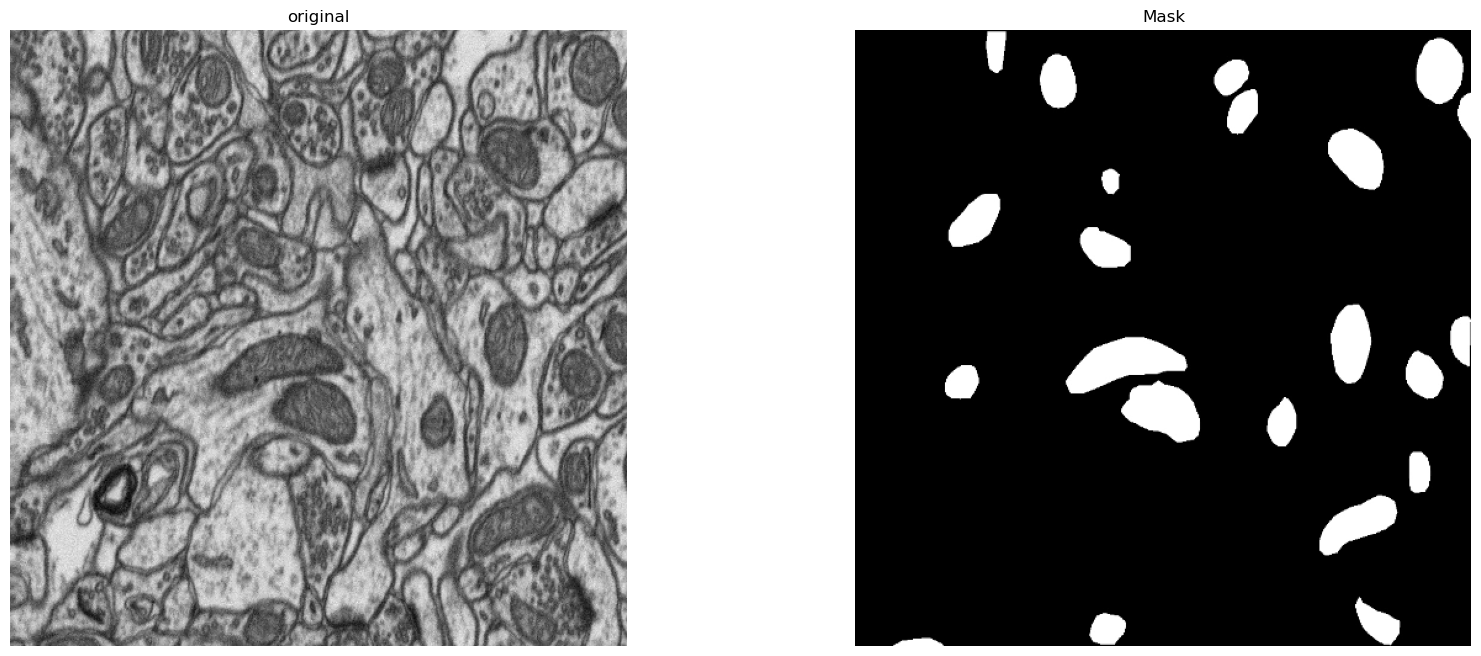

In [20]:
Size=500

img=os.listdir(r"C:\Users\sanch\epfl\Train\images")
mask=os.listdir(r"C:\Users\sanch\epfl\Train\masks")
image=Load_image(r"C:\Users\sanch\epfl\Train\images\{}".format(img[0]),Size)
label=Load_image(r"C:\Users\sanch\epfl\Train\masks\{}".format(mask[0]),Size)

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
show_image(image,"original")
plt.subplot(1,2,2)
show_image(label,"Mask")

In [22]:
def decoder_block(input,skip_features, num_filters,conv_padding=False,zero_pad=False):

    x= Conv2DTranspose(num_filters, 2, activation = 'relu',strides=(2,2), kernel_initializer = 'he_normal')(input)

    if zero_pad == True:
      x=ZeroPadding2D((1,1))(x)
    
    if conv_padding ==True:
        x=Conv2D(num_filters, 3, activation = 'relu', padding='same', kernel_initializer = 'he_normal')(x)
    else:
        x=Conv2D(num_filters, 2, activation = 'relu', kernel_initializer = 'he_normal')(x)
    
    x = Add()([x, skip_features])
    return x

In [23]:
def Unet_VGG19(input_size,n_classes):
    inp = Input(input_size)

    vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inp)
    
    E0=vgg19.get_layer("block1_conv2").output
    E0=Conv2D(128, 3, activation = 'relu', padding='same')(E0)
    E0=Conv2D(64, 3, activation = 'relu', padding='same')(E0)
    
    E1=vgg19.get_layer("block1_pool").output
    E1=Conv2D(128, 3, activation = 'relu', padding='same')(E1)
    E1=Conv2D(64, 3, activation = 'relu', padding='same')(E1)
    
    E2=vgg19.get_layer("block2_pool").output
    E2=Conv2D(128, 3, activation = 'relu', padding='same')(E2)
    
    E3=vgg19.get_layer("block3_pool").output
    E3=Conv2D(512, 3, activation = 'relu', padding='same')(E3)
    E3=Conv2D(256, 3, activation = 'relu', padding='same')(E3)
    
    E4=vgg19.get_layer("block4_pool").output
    E4=Conv2D(1024, 3, activation = 'relu', padding='same')(E4)
    E4=Conv2D(512, 3, activation = 'relu', padding='same')(E4)
    
    B1=vgg19.get_layer("block5_pool").output
    B1=Conv2D(1024, 3, activation = 'relu', padding='same')(B1)
    
    D1=decoder_block(B1,E4,512,zero_pad=True)
    D2=decoder_block(D1,E3,256,conv_padding=True)
    D3=decoder_block(D2,E2,128,zero_pad=True)
    D4=decoder_block(D3,E1,64,conv_padding=True)
    D5=decoder_block(D4,E0,64,conv_padding=True)

    outputs=Conv2D(n_classes, 1, activation = 'sigmoid', padding = 'same')(D5)
    model = Model(inp,outputs, name="VGG19_U-Net")
    model.compile(optimizer = Adam(learning_rate = 1e-4), loss ='binary_crossentropy', metrics = ['accuracy' , tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1],threshold=0.6,name="IOU")])
    model.summary()
    return model

In [24]:
!pip install h5py

In [25]:
model=Unet_VGG19(input_size=(500,500,3),n_classes=1)


Model: "VGG19_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500, 500, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 500, 500, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 500, 500, 64  36928       ['block1_conv1[0][0]']           
                                )                                                       

In [26]:
plot_model(model,show_shapes=True,show_layer_names=True,expand_nested=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [27]:
train_path=r"C:\Users\sanch\epfl\Train"

image_datagen = ImageDataGenerator(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    rescale=1/255.)
mask_datagen = ImageDataGenerator(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest',
                    rescale=1/255.)
B_size=1
seed = 1
image_generator = image_datagen.flow_from_directory(
    train_path,
    class_mode=None,
    classes=['images'],
    color_mode='rgb',
    seed=seed,
    batch_size=B_size,
    target_size=(500,500))

mask_generator = mask_datagen.flow_from_directory(
    train_path,
    classes=['masks'],
    color_mode='grayscale',
    class_mode=None,
    seed=seed,
    batch_size=B_size,
    target_size=(500,500))
train_generator = zip(image_generator, mask_generator)

def train_generator_fn():

    for (img,mask) in train_generator:
        yield (img,mask)

Found 165 images belonging to 1 classes.
Found 165 images belonging to 1 classes.


In [28]:
val_path=r"C:\Users\sanch\epfl\Val"

image_datagen = ImageDataGenerator(rescale=1/255.)
mask_datagen = ImageDataGenerator(rescale=1/255.)
B_size=1
seed = 1
image_generator = image_datagen.flow_from_directory(
    val_path,
    class_mode=None,
    classes=['images'],
    color_mode='rgb',
    seed=seed,
    batch_size=B_size,
    target_size=(500,500))

mask_generator = mask_datagen.flow_from_directory(
    val_path,
    classes=['masks'],
    color_mode='grayscale',
    class_mode=None,
    seed=seed,
    batch_size=B_size,
    target_size=(500,500))
val_generator = zip(image_generator, mask_generator)

def val_generator_fn():

    for (img,mask) in val_generator:
        yield (img,mask)

Found 132 images belonging to 1 classes.
Found 132 images belonging to 1 classes.


In [ ]:
model_checkpoint = ModelCheckpoint('CheckPoint.hdf5', monitor='val_loss',verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=4, min_lr=1e-8)
epochs=50
validation_steps=15
with tf.device('/cpu:0'):
    history = model.fit(train_generator_fn(),
                        validation_data=val_generator_fn(),
                        steps_per_epoch=60,
                        validation_steps=validation_steps,
                        epochs=50,
                        callbacks=[model_checkpoint, reduce_lr])

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# train, val acc
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()


In [30]:
test=tiff.imread("testing.tif")
test_mask=tiff.imread("testing_groundtruth.tif")

In [31]:
if not os.path.isdir("Test/images"):
  os.makedirs("Test/images")
if not os.path.isdir("Test/masks"):
  os.makedirs("Test/masks")

In [32]:
for img in range(test.shape[0]):
    img_name = "image_{}.jpg".format(img)
    cv2.imwrite("Test/images/{}".format(img_name), test[img])

for img in range(test_mask.shape[0]):
    mask_name = "mask_{}_L.jpg".format(img)
    cv2.imwrite("Test/masks/{}".format(mask_name), test_mask[img])


In [33]:
test_path=r"C:\Users\sanch\epfl\Test"
test_image_generator = image_datagen.flow_from_directory(
    test_path,
    class_mode=None,
    classes=['images'],
    color_mode='rgb',
    seed=seed,
    batch_size=B_size,
    target_size=(500,500))

test_mask_generator = mask_datagen.flow_from_directory(
    test_path,
    classes=['masks'],
    class_mode=None,
    seed=seed,
    color_mode='grayscale',
    batch_size=B_size,
    target_size=(500,500))

test_generator = zip(test_image_generator, test_mask_generator)

def test_generator_fn():
    for (img,mask) in test_generator:
        yield (img,mask)

Found 165 images belonging to 1 classes.
Found 165 images belonging to 1 classes.


In [34]:
model.evaluate(test_generator_fn(),steps=165,batch_size=1)


165/165 [==============================] - 27s 105ms/step - loss: 0.1087 - accuracy: 0.9592 - IOU: 0.7163


[0.10865321010351181, 0.9592424631118774, 0.7163467407226562]

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.ylim([0, 0.5])
plt.xlabel('Epoch')
plt.xlim([0, 50])
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# train, val accuracy 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()
